# Chapter 18 – Reinforcement Learning

This notebook contains all the sample code and solutions to the exercises in chapter 18.

## Setup
This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

**Warning**: the latest TensorFlow versions are based on Keras 3. For chapters 10-15, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter, in particular adding custom losses using the functional API is not implemented yet. So for this chapter I've had to revert to Keras 2. To do that, I set the TF_USE_LEGACY_KERAS environment variable to "1" and import the tf_keras package. This ensures that tf.keras points to tf_keras, which is Keras 2.*.

In [2]:
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

And TensorFlow ≥ 2.8:

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [4]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the images/rl folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [7]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes**:

- OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the announcement), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install gymnasium instead of gym, and import gymnasium as gym, and everything should work fine.
- By running the following cell, you accept the Atari ROM license.

In [8]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari]

## Introduction to ~OpenAI gym~ Gymnasium
In this notebook we will be using gymnasium, a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning agents to interact with. Let's import Gym and make a new CartPole environment:

In [9]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: ```gym.envs.registry``` is a dictionary containing all available environments:

In [10]:
# extra code – shows the first few environments
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

In [11]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling its ```reset()``` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [12]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [13]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its render() method. If you set render_mode to "rgb_array" when creating the environment, then this will return a NumPy array.

In [15]:
img = env.render()
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

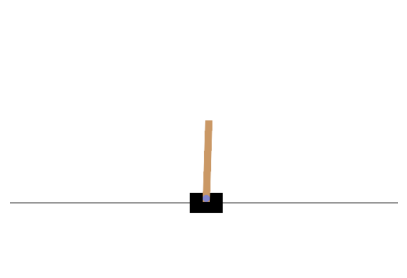

In [16]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [17]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (obs[2] > 0), let's accelerate the cart toward the right:

In [18]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)


Notice that the cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

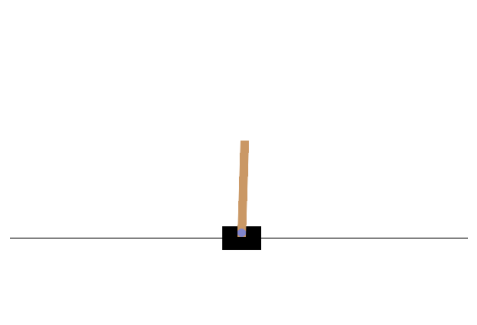

In [19]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [20]:
reward

1.0

When the game is over, the environment returns done=True. In this case, it's not over yet:

In [21]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, truncated will be set to True. In this case, it's not truncated yet:

In [22]:
truncated

False

Finally, ```info``` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [23]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when ```step()``` returns ```done=True``` or ```truncated=True```), you should reset the environment before you continue to use it.

In [24]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a policy for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

## A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and vice versa. Let's see if that works:

In [25]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [26]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the Matplotlib tutorial notebook.